In [1]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
im_shape = (299,299)

TRAINING_DIR = 'input/ds_frutas_am/train'
TEST_DIR = 'input/ds_frutas_am/test'

seed = 10

BATCH_SIZE = 16

In [3]:
data_generator = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)

In [4]:
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")
# Generator para parte validação
validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

# Generator para dataset de teste
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.
Found 30 images belonging to 6 classes.
Classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


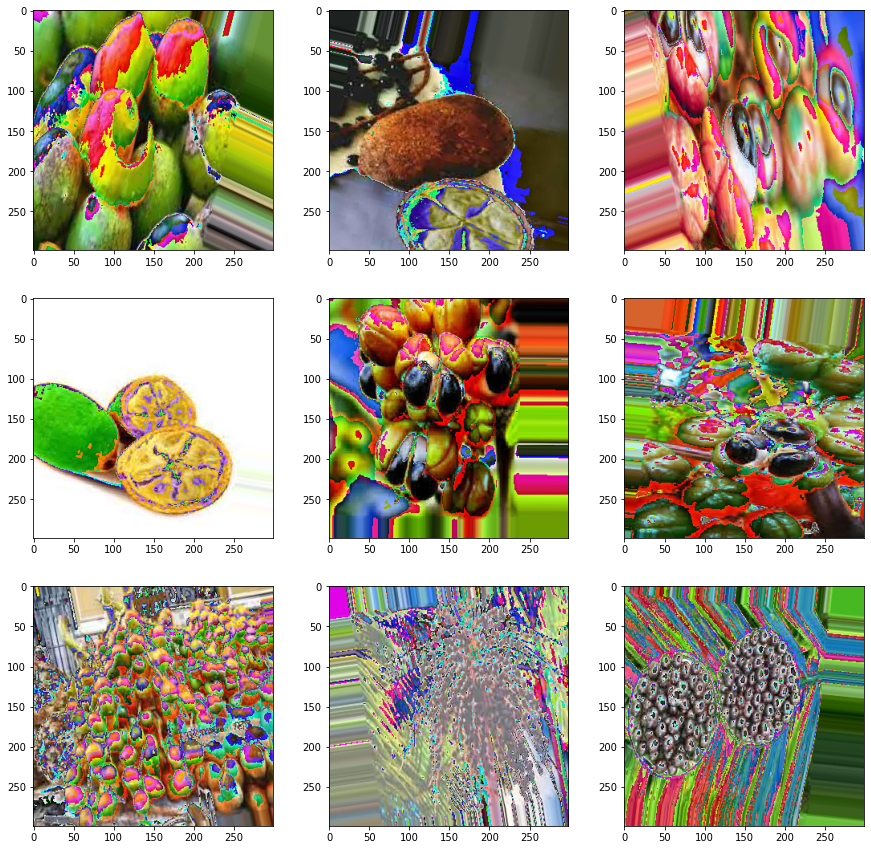

In [5]:
plt.figure(figsize=(15,15))
for i in range(9):
    #gera subfigures
    plt.subplot(330 + 1 + i)
    batch = train_generator.next()[0]*255
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [6]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(im_shape[0], im_shape[1], 3))

x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer='random_uniform')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing pretrained layers
for layer in base_model.layers:
    layer.trainable=False
    
optimizer = Adam()
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [7]:
epochs = 80

# Saving the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/80
4/4 [==============================] - 25s 5s/step - loss: 3.6289 - accuracy: 0.2500 - val_loss: 3.6112 - val_accuracy: 0.5625

Epoch 00001: val_loss improved from inf to 3.61122, saving model to model.h5
Epoch 2/80
4/4 [==============================] - 16s 4s/step - loss: 1.8657 - accuracy: 0.5714 - val_loss: 1.3613 - val_accuracy: 0.4375

Epoch 00002: val_loss improved from 3.61122 to 1.36128, saving model to model.h5
Epoch 3/80
4/4 [==============================] - 16s 4s/step - loss: 1.1353 - accuracy: 0.6786 - val_loss: 0.7477 - val_accuracy: 0.7500

Epoch 00003: val_loss improved from 1.36128 to 0.74766, saving model to model.h5
Epoch 4/80
4/4 [==============================] - 15s 4s/step - loss: 0.4396 - accuracy: 0.8393 - val_loss: 0.6790 - val_accuracy: 0.6250

Epoch 00004: val_loss improved from 0.74766 to 0.67900, saving model to model.h5
Epoch 5/80
4/4 [==============================] - 16s 4s/step - loss: 0.6625 - accuracy: 0.8214 - val_loss: 0.4586 - val_acc

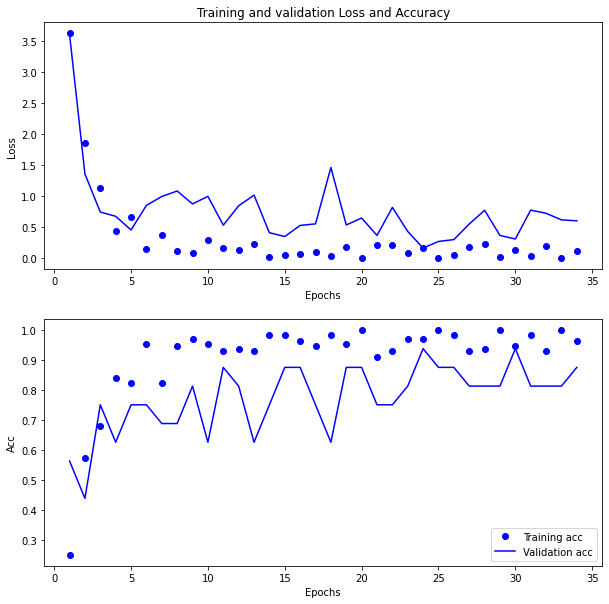

In [8]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [9]:
from tensorflow.keras.models import load_model
# Load the best saved model
model = load_model('model.h5')

In [10]:
score = model.evaluate_generator(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Val loss: 0.39704152941703796
Val accuracy: 0.8888888955116272


In [11]:
score = model.evaluate_generator(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5637167692184448
Test accuracy: 0.8333333134651184


In [12]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Classification Report
              precision    recall  f1-score   support

        acai       1.00      0.80      0.89         5
     cupuacu       1.00      0.80      0.89         5
    graviola       1.00      1.00      1.00         5
     guarana       1.00      0.80      0.89         5
     pupunha       0.56      1.00      0.71         5
      tucuma       0.75      0.60      0.67         5

    accuracy                           0.83        30
   macro avg       0.88      0.83      0.84        30
weighted avg       0.88      0.83      0.84        30



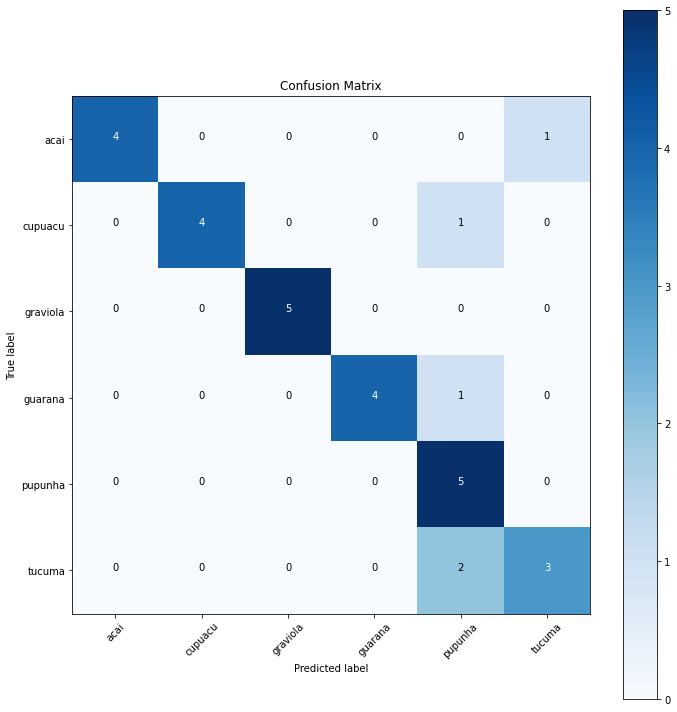

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_generator)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confution Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))